In [2]:
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation

Dataset URL: https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation
License(s): other
 99%|███████████████████████████████████████▋| 171M/172M [00:08<00:00, 26.3MB/s]
100%|████████████████████████████████████████| 172M/172M [00:08<00:00, 21.6MB/s]


In [3]:
!unzip augmented-forest-segmentation.zip

Archive:  augmented-forest-segmentation.zip
  inflating: Forest Segmented/Forest Segmented/images/10452_sat_08.jpg  
  inflating: Forest Segmented/Forest Segmented/images/10452_sat_18.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_00.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_01.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_02.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_03.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_04.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_07.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_08.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_10.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_12.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_13.jpg  
  inflating: Forest Segmented/Forest Segmented/images/111335_sat_15.jp

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import torch
import os
from PIL import Image
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchutils as tu
import matplotlib.pyplot as plt

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
import numpy as np
from torch.utils.data import random_split

In [3]:
from data.model import UNet_orig

In [4]:
BATCH_SIZE = 32
NUM_WORKERS = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class ForestSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Маски в оттенках серого

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [7]:
dataset = ForestSegmentationDataset(
    images_dir='/home/skdnv/Desktop/umap/Forest_Segmented/Forest_Segmented/images', 
    masks_dir='/home/skdnv/Desktop/umap/Forest_Segmented/Forest_Segmented/masks', 
    image_transform=transform,
    mask_transform=mask_transform
)

In [8]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

In [9]:
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [11]:
model = UNet_orig(1)
model.to(DEVICE)
fake_batch = torch.randn(4, 3, 256, 256, device=DEVICE)

In [12]:
tu.get_model_summary(model, fake_batch)

Layer              Kernel               Output          Params              FLOPs
0_e11             [3, 64, 3, 3]    [4, 64, 256, 256]       1,792      469,762,048
1_e12            [64, 64, 3, 3]    [4, 64, 256, 256]      36,928    9,680,453,632
2_pool1                       -    [4, 64, 128, 128]           0                0
3_e21           [64, 128, 3, 3]   [4, 128, 128, 128]      73,856    4,840,226,816
4_e22          [128, 128, 3, 3]   [4, 128, 128, 128]     147,584    9,672,065,024
5_pool2                       -     [4, 128, 64, 64]           0                0
6_e31          [128, 256, 3, 3]     [4, 256, 64, 64]     295,168    4,836,032,512
7_e32          [256, 256, 3, 3]     [4, 256, 64, 64]     590,080    9,667,870,720
8_pool3                       -     [4, 256, 32, 32]           0                0
9_e41          [256, 512, 3, 3]     [4, 512, 32, 32]   1,180,160    4,833,935,360
10_e42         [512, 512, 3, 3]     [4, 512, 32, 32]   2,359,808    9,665,773,568
11_pool4        

In [13]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [15]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()
    
    ax[1].plot(history['train_metric'], label='train acc')
    ax[1].plot(history['valid_metric'], label='valid acc')
    ax[1].set_title(f'Metric on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()
    
    plt.show()

In [16]:
def calculate_iou(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).float().sum((1, 2))
    union = torch.logical_or(pred_mask, true_mask).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # избегаем деления на ноль
    return iou.mean().item()

In [17]:



def aim_fit_model(
        model, 
        epochs=10, 
        optimizer=optimizer, 
        criterion=criterion,
        train_loader=train_loader,
        valid_loader=valid_loader,
        device=DEVICE,
        history=None
        ) -> dict:
    
    aim_run = Run()

    aim_run['hparams'] = {
        'epochs': epochs,
        'learning_rate': optimizer.defaults['lr'],
        'batch_size': train_loader.batch_size
    }

    history = history or {
        'train_metric': [],
        'train_losses': [],
        'valid_metric': [],
        'valid_losses': [],
    }

    start_epoch = len(history['train_metric'])
    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_ious = []
        batch_losses = [] 
        for samples, labels in train_loader: 
            
            samples = samples.to(device)
            labels = labels.to(device)
            
            y_pred = model(samples)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            pred_probs = torch.sigmoid(y_pred)
            pred_masks = (pred_probs > 0.5).float()
            batch_ious.append(calculate_iou(pred_masks, labels))

        train_loss = np.mean(batch_losses)
        train_iou = np.mean(batch_ious)
        history['train_losses'].append(train_loss)
        history['train_metric'].append(train_iou)

        aim_run.track({'loss': train_loss, 'iou': train_iou}, epoch=epoch, context={'subset': 'train'})
        track_params_dists(model, aim_run)
        track_gradients_dists(model, aim_run)

        model.eval()
        batch_ious = []
        batch_losses = []
        with torch.no_grad():
            for samples, labels in valid_loader:
                samples, labels = samples.to(device), labels.to(device)
                y_pred = model(samples)
                loss = criterion(y_pred, labels)
                batch_losses.append(loss.item())
                pred_probs = torch.sigmoid(y_pred)
                pred_masks = (pred_probs > 0.5).float()
                batch_ious.append(calculate_iou(pred_masks, labels))

        valid_loss = np.mean(batch_losses)
        valid_iou = np.mean(batch_ious)
        history['valid_metric'].append(valid_iou)
        history['valid_losses'].append(valid_loss)

        aim_run.track({'loss': valid_loss, 'iou': valid_iou}, epoch=epoch, context={'subset': 'valid'})

        print(
            f'train: IoU {train_iou:.4f}, loss {train_loss:.4f}\n'
            f'valid: IoU {valid_iou:.4f}, loss {valid_loss:.4f}'
        )
        print(f'{"-"*35}')
        print()
    
    plot_history(history)

    return history

------------- Epoch 1 -------------
train: IoU 0.5236, loss 0.6130
valid: IoU 0.6273, loss 0.5424
-----------------------------------

------------- Epoch 2 -------------
train: IoU 0.6315, loss 0.5400
valid: IoU 0.6621, loss 0.5095
-----------------------------------

------------- Epoch 3 -------------
train: IoU 0.6380, loss 0.5168
valid: IoU 0.6706, loss 0.4918
-----------------------------------

------------- Epoch 4 -------------
train: IoU 0.6471, loss 0.4988
valid: IoU 0.6884, loss 0.4760
-----------------------------------

------------- Epoch 5 -------------
train: IoU 0.6588, loss 0.4791
valid: IoU 0.6862, loss 0.4514
-----------------------------------

------------- Epoch 6 -------------
train: IoU 0.6653, loss 0.4696
valid: IoU 0.6851, loss 0.4689
-----------------------------------

------------- Epoch 7 -------------
train: IoU 0.6725, loss 0.4638
valid: IoU 0.6536, loss 0.5133
-----------------------------------

------------- Epoch 8 -------------
train: IoU 0.6761, 

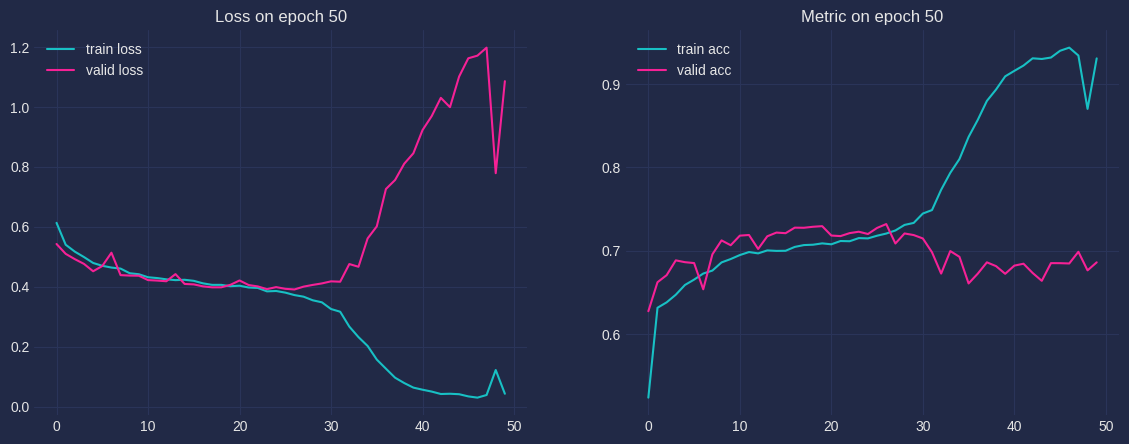

In [56]:
logs = aim_fit_model(model, 50)

In [18]:
from aim import Run
from aim.pytorch import track_gradients_dists, track_params_dists

def aim_fit_model(
        model, 
        epochs=10, 
        optimizer=optimizer, 
        criterion=criterion,
        train_loader=train_loader,
        valid_loader=valid_loader,
        device=DEVICE,
        history=None
        ) -> dict:
    
    aim_run = Run()

    aim_run['hparams'] = {
        'epochs': epochs,
        'learning_rate': optimizer.defaults['lr'],
        'batch_size': train_loader.batch_size
    }

    history = history or {
        'train_metric': [],
        'train_losses': [],
        'valid_metric': [],
        'valid_losses': [],
    }
    
    best_valid_metric = float('-inf')
    best_state_dict = None

    start_epoch = len(history['train_metric'])
    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_ious = []
        batch_losses = [] 
        for samples, labels in train_loader: 
            
            samples = samples.to(device)
            labels = labels.to(device)
            
            y_pred = model(samples)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            pred_probs = torch.sigmoid(y_pred)
            pred_masks = (pred_probs > 0.5).float()
            batch_ious.append(calculate_iou(pred_masks, labels))

        train_loss = np.mean(batch_losses)
        train_iou = np.mean(batch_ious)
        history['train_losses'].append(train_loss)
        history['train_metric'].append(train_iou)

        aim_run.track({'loss': train_loss, 'iou': train_iou}, epoch=epoch, context={'subset': 'train'})
        track_params_dists(model, aim_run)
        track_gradients_dists(model, aim_run)

        model.eval()
        batch_ious = []
        batch_losses = []
        with torch.no_grad():
            for samples, labels in valid_loader:
                samples, labels = samples.to(device), labels.to(device)
                y_pred = model(samples)
                loss = criterion(y_pred, labels)
                batch_losses.append(loss.item())
                pred_probs = torch.sigmoid(y_pred)
                pred_masks = (pred_probs > 0.5).float()
                batch_ious.append(calculate_iou(pred_masks, labels))

        valid_loss = np.mean(batch_losses)
        valid_iou = np.mean(batch_ious)
        history['valid_metric'].append(valid_iou)
        history['valid_losses'].append(valid_loss)

        aim_run.track({'loss': valid_loss, 'iou': valid_iou}, epoch=epoch, context={'subset': 'valid'})

        print(
            f'train: IoU {train_iou:.4f}, loss {train_loss:.4f}\n'
            f'valid: IoU {valid_iou:.4f}, loss {valid_loss:.4f}'
        )
        print(f'{"-"*35}')
        print()
        
        if valid_iou > best_valid_metric:
            best_valid_metric = valid_iou
            best_state_dict = model.state_dict()
            torch.save(best_state_dict, 'data/best_model.pt')
            print(f'New best model saved with IoU {valid_iou:.4f}')
    
    plot_history(history)

    return history

------------- Epoch 1 -------------
train: IoU 0.6027, loss 0.6235
valid: IoU 0.6358, loss 0.5672
-----------------------------------

New best model saved with IoU 0.6358
------------- Epoch 2 -------------
train: IoU 0.6241, loss 0.5458
valid: IoU 0.6562, loss 0.5520
-----------------------------------

New best model saved with IoU 0.6562
------------- Epoch 3 -------------
train: IoU 0.6332, loss 0.5210
valid: IoU 0.6455, loss 0.5090
-----------------------------------

------------- Epoch 4 -------------
train: IoU 0.6522, loss 0.4924
valid: IoU 0.6566, loss 0.4877
-----------------------------------

New best model saved with IoU 0.6566
------------- Epoch 5 -------------
train: IoU 0.6543, loss 0.4878
valid: IoU 0.6743, loss 0.4727
-----------------------------------

New best model saved with IoU 0.6743
------------- Epoch 6 -------------
train: IoU 0.6664, loss 0.4680
valid: IoU 0.6806, loss 0.4686
-----------------------------------

New best model saved with IoU 0.6806
-----

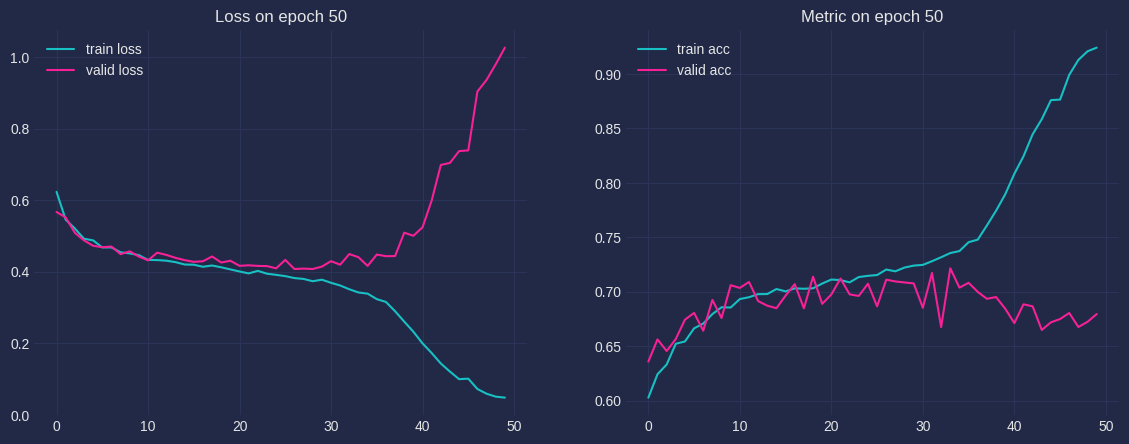

In [19]:
logs_new = aim_fit_model(model, 50)

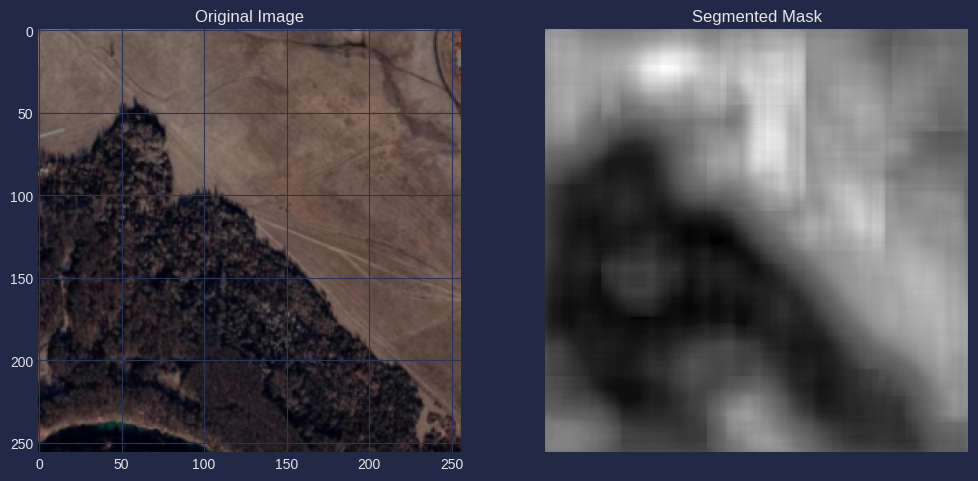

In [20]:
from torchvision import io

img_path = '/home/skdnv/Desktop/umap/123'

# Загрузка изображения
img = io.read_image(img_path)

# Преобразования, если они необходимы, например изменение размера или нормализация
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Пример изменения размера
])

# Применение преобразований к изображению
img = transform(img.float() / 255.0)  # Добавляем batch размерность

# Прогон изображения через модель
with torch.inference_mode():
    output = model(img.unsqueeze(0).to(DEVICE))

# Получение маски сегментации
# output = torch.sigmoid(output)
pred_mask = output.squeeze().cpu().numpy()

# Отображение исходного изображения и предсказанной маски
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray_r')
plt.title("Segmented Mask")
plt.axis('off')

plt.show()

In [28]:
torch.save(model.state_dict(), 'data/model.pt')